In [1]:
import os
import pickle

import pandas as pd

mapper_tests = {}


def get_objs_by_folder():
    directory = 'results'
    objs = []
    for root, subdirs, files in os.walk(directory):
        if root != 'results':
            tests_list = []
            for file in files:
                if file != '.DS_Store':
                    tests_list.append(file)
                    f = os.path.join(directory, str(root).split('/')[1] + '/' + file)
                    if os.path.isfile(f) and file.endswith('data'):
                        with open(f, 'rb') as filehandle:
                            # read the data as binary data stream
                            while 1:
                                try:
                                    objs.append(pickle.load(filehandle))
                                except EOFError:
                                    break
            mapper_tests[str(root).split('/')[1]] = tests_list
    return objs


# get_objs_by_folder()


def get_objs():
    directory = 'results'
    objs = []
    for k in mapper_tests.keys():
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename + '/' + k)
            if os.path.isfile(f) and filename.endswith('data'):
                with open(f, 'rb') as filehandle:
                    # read the data as binary data stream
                    while 1:
                        try:
                            objs.append(pickle.load(filehandle))
                        except EOFError:
                            break
        return objs

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from face_recognition.api import get_known_people_from_dataset


['alex', 'alex(high movement)', 'alex(low light)', 'alex96', 'andra', 'cosmin', 'cosmin(2)', 'costi', 'costi(2)', 'costis', 'daniel', 'diana', 'diana(2)', 'f', 'ioana', 'ioana(2)', 'mom', 'mom(2)', 'raed', 'raluca', 'raluca(2)', 'stefan', 'stefan(2)', 'test_person_1', 'tomsa_s', 'twin1', 'twin2', 'yt1', 'yt2', 'yt3', 'yt3(2)', 'yt4']
32


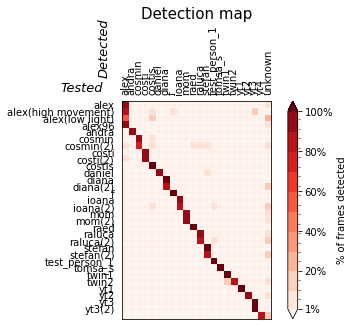

(32, 22)
32
22


In [3]:
#TODO: get detection percentage out of every person

unique_people = []


def generate_matrix_data(objs):
    people_list = []
    objs.sort(key=lambda x: x[0])
    for idx, results in enumerate(objs):
        if not results[0].startswith('stock'):
            people_list.append(results[0])

    unwanted_list = remove_unwanted_cols(people_list)
    lst = list(filter(lambda x: not x[0].startswith('stock'), objs))
    person_data = list(filter(lambda x: x[0] not in unwanted_list, lst))
    for data in person_data:
        unique_people.append(data[0])
    unique_people.append('unknown')
    size = len(lst)

    objs = lst
    matrix_data = np.zeros((size, len(unique_people)), dtype=np.float64)
    mapper = {'unknown': size}
    for idx, results in enumerate(objs):
        actual_name = results[0]
        mapper[actual_name] = idx

    for idx, results in enumerate(objs):
        actual_name = results[0]
        output_faces = results[1]
        # print(actual_name, output_faces)

        for name, count in output_faces.items():
            if name in mapper.keys():
                X = 100 * count / sum(output_faces.values())
                # print(actual_name, name)
                # print(int(mapper[actual_name]), int(mapper[name]))
                index = unique_people.index(name)
                matrix_data[int(mapper[actual_name])][index] = X

    print(people_list)
    print(len(people_list))
    return matrix_data, people_list, unique_people


def remove_unwanted_cols(people_list):
    unwanted_list = []
    dataset_people = get_known_people_from_dataset()
    for f in mapper_tests.values():
        for t in f:
            split = t.split('.data')[0]
            if split in people_list and split not in dataset_people:
                unwanted_list.append(split)
    return unwanted_list


pass


def plot_matrix(arr, people_list):
    fig, ax = plt.subplots()
    ax.matshow(arr, aspect='auto', cmap='Reds', interpolation='none')

    ax.set_xticks(list(range(len(unique_people))))
    ax.set_xticklabels(unique_people)

    ax.set_yticks(list(range(len(people_list) - 1)))
    ax.set_yticklabels(people_list[:-1])

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.xticks(rotation=90)
    plt.title("Detection map", fontsize=15)
    fig.set_facecolor("white")

    bounds = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    cmap = mpl.cm.Reds
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
    pos_neg_clipped = ax.imshow(arr, cmap="Reds",
                                interpolation='none', norm=norm)
    cbar = fig.colorbar(pos_neg_clipped, ax=ax, format='%.0f%' + '%', spacing='proportional',
                        extend='both',
                        label='% of frames detected')
    ax.text(-9.5, -2, r'Tested', style='italic', fontsize=13, weight='light')
    ax.text(-4, -4.5, r'Detected', style='italic', fontsize=13, rotation='vertical', weight='light')
    cbar.minorticks_on()

    plt.grid(color='r', linestyle='-.', linewidth=0.05)

    plt.show()


objs = get_objs_by_folder()
matrix_data, people_list, unique_people = generate_matrix_data(objs)
plot_matrix(matrix_data, people_list)
np.set_printoptions(precision=1)

print(matrix_data.shape)
print(len(people_list))
print(len(unique_people))

df = pd.DataFrame(data=np.round(matrix_data, 1), index=people_list, columns=unique_people)
df.to_csv("output_dataframe.csv", index=True, header=True)
